<a href="https://colab.research.google.com/github/DarShabi/OCR-Company-Project/blob/main/Week%234/Iinitial_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q ImageHash

In [2]:
!apt-get install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [3]:
! pip install fasttext

In [4]:
!pip install requests

In [5]:
!pip install transformers

In [6]:
from PIL import Image
from PIL import ImageEnhance, ImageOps
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import requests
import glob
import json
from collections import Counter, defaultdict
import re
import matplotlib.image as mpimg
import seaborn as sns
import cv2
import imagehash
import pytesseract
import fasttext
from sklearn.model_selection import train_test_split
import cv2
import re
import urllib.request
import time
from sklearn.metrics import confusion_matrix
import itertools
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, PreTrainedTokenizer,  GPT2Tokenizer
import torch

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
data_path = '/content/drive/MyDrive/OCR_Project/data.csv'

df = pd.read_csv(data_path)

In [9]:
NA_df = pd.read_csv('/content/drive/MyDrive/OCR_Project/N_A_images.csv')

In [10]:
NA_df['text'].fillna('unknown', inplace=True)

In [11]:
display(NA_df)

,file_path,text
0,/content/drive/MyDrive/Data/Data_samples/forum...,The image you are\nreque sting does not exist\...
1,/content/drive/MyDrive/Data/Data_samples/forum...,Sorry.\nThis Image Is currently\nUnavailable\n...
2,/content/drive/MyDrive/Data/Data_samples/forum...,unknown
3,/content/drive/MyDrive/Data/Data_samples/forum...,unknown
4,/content/drive/MyDrive/Data/Data_samples/forum...,Your IP is\nblacklisted\n
5,/content/drive/MyDrive/Data/Data_samples/forum...,taypie\nThis image is no longer available.\nVi...
6,/content/drive/MyDrive/Data/Data_samples/forum...,VA Pixs.ru\nXS\nЗАГРУЗИТЕ ФОто CНОВA\n
7,/content/drive/MyDrive/Data/Data_samples/forum...,Запрашиваемое изображение\nне существует или б...
8,/content/drive/MyDrive/Data/Data_samples/Data ...,Hacked by Farel


In [12]:
display(df)

,file_path,text
0,/content/drive/MyDrive/Data/Data_samples/forum...,Aloha\nW LEREEE\n3imL.\nT19\nucket\nAIR CALIFO...
1,/content/drive/MyDrive/Data/Data_samples/forum...,TAM\nVAAIR sano oCTORS\n*****\nphotobuckeł\nSI...
2,/content/drive/MyDrive/Data/Data_samples/forum...,Pre-Production Photo\ns ON\n909\n909\n5265\nTh...
3,/content/drive/MyDrive/Data/Data_samples/forum...,AIRCANADA\n.......\n..................\nWings9...
4,/content/drive/MyDrive/Data/Data_samples/forum...,DRAGON\nE Asiana\nisiviu ini\n- Asiana Airline...
...,...,...
4863,/content/drive/MyDrive/Data/Data_samples/Data ...,hacked by Kro0oz\n
4864,/content/drive/MyDrive/Data/Data_samples/Data ...,HACKED BY KINGSAN PAKISTAN ZINDABAD KASHMIR ZI...
4865,/content/drive/MyDrive/Data/Data_samples/Data ...,Hacked By KingSkrupellos CyBe RIZM\nTechnologi...
4866,/content/drive/MyDrive/Data/Data_samples/Data ...,"Hacked By Mr.Kro0oz.305\nKrZSec\n""Everything's..."


# PreProcess - changing NaN to string 'unknown'

In [13]:
nan_count_before = df['text'].isnull().sum()
print(f"Number of NaN values before replacement: {nan_count_before}")

Number of NaN values before replacement: 1031


In [14]:
# Replace 'NaN' with 'unknown'
df['text'].fillna('unknown', inplace=True)

In [15]:
# Check the count of 'NaN' after replacement
nan_count_after = df['text'].isnull().sum()
print(f"Number of NaN values after replacement: {nan_count_after}")

Number of NaN values after replacement: 0


In [16]:
# Initial split: 80% train, 20% temp
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)

# Split the 20% temp into half: 10% validation, 10% test
val_df, test_df = train_test_split(temp_df, test_size=2/3, random_state=42)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")


Train size: 3407
Validation size: 487
Test size: 974


# Step 1: Solving N/A and one-pixle images

In [17]:
# Calculate hashes for all images in na_df and store their respective texts
hashes_na = {}
for index, row in NA_df.iterrows():
    image_path = row['file_path']
    with Image.open(image_path) as img:
        h = imagehash.dhash(img)
        hashes_na[h] = row['text']

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [18]:
# Calculate hashes for all images in val_df and assign matching predicted_text
for index, row in val_df.iterrows():
    image_path = row['file_path']
    with Image.open(image_path) as img:
        h = imagehash.dhash(img)
        if h in hashes_na:
            val_df.at[index, 'predicted_text'] = hashes_na[h]
        else:
            val_df.at[index, 'predicted_text'] = 'TBD'

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [19]:
correct_predictions = (val_df['predicted_text'] == val_df['text']).sum()
total_predictions = len(val_df)
accuracy = (correct_predictions / total_predictions) * 100
print(f"Accuracy after accounting for visually similar images: {accuracy:.4f}%")

Accuracy after accounting for visually similar images: 7.8029%


In [20]:
def find_one_color_images(df, column_name='file_path'):
    """
    Identifies images in the given DataFrame that consist of a single color.

    Parameters:
    df (DataFrame): A DataFrame containing file paths to the images.
    column_name (str, optional): The name of the column in the DataFrame containing the file paths. Defaults to 'file_path'.

    Returns:
    list: A list of file paths to the images that consist of a single color.
    """
    one_color_images = []

    for index, row in df.iterrows():
        image_path = row[column_name]
        image = Image.open(image_path).convert("RGB")
        pixels = np.array(image)
        first_pixel = pixels[0, 0]

        if (pixels == first_pixel).all():
            one_color_images.append(image_path)

    return one_color_images

In [21]:
def set_nan_for_one_color_images(df, one_color_images):
    """
    Set the prediction to unknown for one-color images.

    Parameters:
    df (DataFrame): The DataFrame containing the image paths and their predictions.
    one_color_images (list): The list of image paths that are one-color images.

    Returns:
    DataFrame: Updated DataFrame with predictions set to unknown for one-color images.
    """
    for img_path in one_color_images:
        df.loc[df['file_path'] == img_path, 'predicted_text'] = 'unknown'
    return df


In [22]:
tbd_rows = val_df[val_df['predicted_text'] == 'TBD']
# Identify one-color images in the filtered rows
one_color_images_tbd = find_one_color_images(tbd_rows)
print(f'Number of one-color images in val_df {len(one_color_images_tbd)}')

Number of one-color images in val_df 0


In [23]:
# Update the val_df to set predictions to 'unknown' for the identified one-color images
val_df = set_nan_for_one_color_images(val_df, one_color_images_tbd)

In [24]:
correct_predictions = ((val_df['predicted_text'] == val_df['text'])).sum()

total_predictions = len(val_df)

accuracy = (correct_predictions / total_predictions) * 100

print(f"Accuracy after handling 'n_a_images' and one-color images: {accuracy:.4f}%")


Accuracy after handling 'n_a_images' and one-color images: 7.8029%


# Step 2: Solving no text images.

## With EAST (OpenCV)

In [25]:
val_df_east=val_df.copy()

In [26]:
URL = "https://github.com/oyyd/frozen_east_text_detection.pb/raw/master/frozen_east_text_detection.pb"
MODEL_PATH = "frozen_east_text_detection.pb"

response = requests.get(URL, stream=True)

# Check if the request was successful
if response.status_code == 200:
    with open(MODEL_PATH, "wb") as file:
        # Write the contents to a file
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
    print(f"'{MODEL_PATH}' downloaded successfully!")
else:
    print("Error downloading the model. Check the URL or your connection.")


'frozen_east_text_detection.pb' downloaded successfully!


In [27]:
# Load the pre-trained EAST model
net = cv2.dnn.readNet('frozen_east_text_detection.pb')

In [28]:
counter_east=0

In [29]:
def detect_text_east(image_path):
    global counter_east
    counter_east+=1
    # Read image
    image = cv2.imread(image_path)
    if image is None:
      print(f"Failed to read image at {image_path}. Skipping...")
      return False

    start_time = time.time()

    orig = image.copy()
    (H, W) = image.shape[:2]

    # Set the new width and height and then determine the ratio in change
    (newW, newH) = (320, 320)
    rW = W / float(newW)
    rH = H / float(newH)

    # Resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]

    # Define the two output layer names for the EAST detector model
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"]

    # Convert image to blob for DNN
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
        (123.68, 116.78, 103.94), swapRB=True, crop=False)

    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)

    # Decode the predictions
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(0, numCols):
            if scoresData[x] < 0.4:
                continue

            # Compute the offset factor
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # Extract the rotation angle for the prediction and compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # Use the geometry volume to derive the width and height of the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # Compute both the starting and ending (x, y)-coordinates for the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
    elapsed_time = time.time() - start_time
    print(f"Processed {counter_east} images. Current image took: {elapsed_time:.2f} seconds.")
    # Return True if we found some text regions with high confidence
    return len(confidences) > 0 and max(confidences) > 0.45

In [30]:
val_df_east.loc[val_df_east['predicted_text'] == 'TBD', 'predicted_text'] = val_df_east[val_df_east['predicted_text'] == 'TBD']['file_path'].apply(lambda x: 'TBD' if detect_text_east(x) else 'unknown')

Failed to read image at /content/drive/MyDrive/Data/Data_samples/forum_anticollector/8fe1f01474df8aebbbc5af5532bac507.jpg. Skipping...
Processed 2 images. Current image took: 1.62 seconds.
Processed 3 images. Current image took: 0.83 seconds.
Processed 4 images. Current image took: 0.61 seconds.
Processed 5 images. Current image took: 0.73 seconds.
Processed 6 images. Current image took: 0.82 seconds.
Failed to read image at /content/drive/MyDrive/Data/Data_samples/forum_dualthegame/610957bdbb43e8039c76ae1b81120836.jpg. Skipping...
Processed 8 images. Current image took: 0.70 seconds.
Processed 9 images. Current image took: 0.67 seconds.
Processed 10 images. Current image took: 0.79 seconds.
Processed 11 images. Current image took: 0.70 seconds.
Processed 12 images. Current image took: 0.49 seconds.
Processed 13 images. Current image took: 0.44 seconds.
Processed 14 images. Current image took: 0.55 seconds.
Processed 15 images. Current image took: 0.64 seconds.
Processed 16 images. Cur

hi

In [31]:
correct_predictions = ((val_df_east['predicted_text'] == val_df_east['text'])).sum()

total_predictions = len(val_df_east)

accuracy = (correct_predictions / total_predictions) * 100

print(f"Accuracy after handling 'n_a_images', one-color images, and no-text images: {accuracy:.4f}%")

Accuracy after handling 'n_a_images', one-color images, and no-text images: 25.0513%


In [32]:
# Rows where 'text' is 'unknown' but 'predicted_text' is not
unknown_text_diff_predicted_val = val_df_east[(val_df_east['text'] == 'unknown') & (val_df_east['predicted_text'] != 'unknown')]

# Rows where 'predicted_text' is 'unknown' but 'text' is not
unknown_predicted_diff_text_val = val_df_east[(val_df_east['predicted_text'] == 'unknown') & (val_df_east['text'] != 'unknown')]

# Calculate percentages
percentage_unknown_text_diff_predicted_val = (len(unknown_text_diff_predicted_val) / len(val_df_east)) * 100
percentage_unknown_predicted_diff_text_val = (len(unknown_predicted_diff_text_val) / len(val_df_east)) * 100

print(f"Percentage where 'text' in val_df is 'unknown' but 'predicted_text' is not: {percentage_unknown_text_diff_predicted_val:.2f}%")
print(f"Percentage where 'predicted_text' in val_df is 'unknown' but 'text' is not: {percentage_unknown_predicted_diff_text_val:.2f}%")

Percentage where 'text' in val_df is 'unknown' but 'predicted_text' is not: 2.46%
Percentage where 'predicted_text' in val_df is 'unknown' but 'text' is not: 10.06%


In [33]:
def display_images_from_df(dataframe, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for idx, (ax, row) in enumerate(zip(axes, dataframe.iterrows())):
        image_path = row[1]['file_path']
        image = Image.open(image_path)
        ax.imshow(image)
        ax.set_title(f"Text: {row[1]['text']}\nPredicted: {row[1]['predicted_text']}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

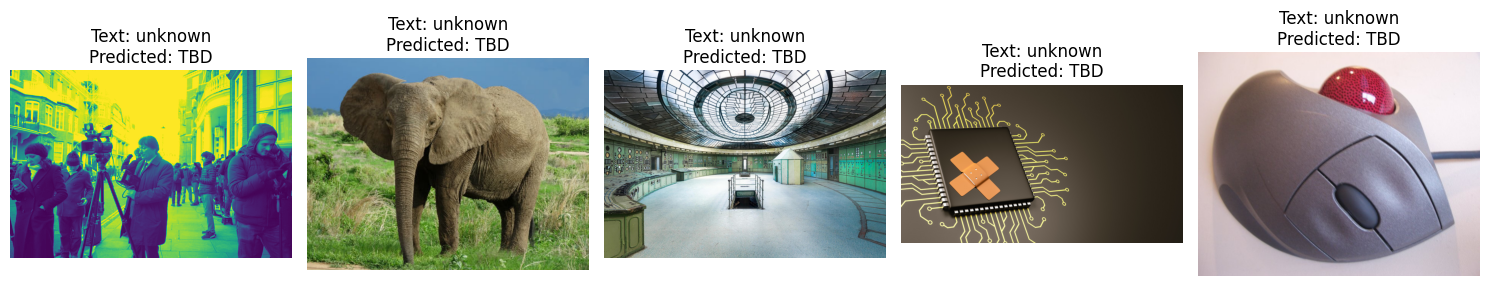

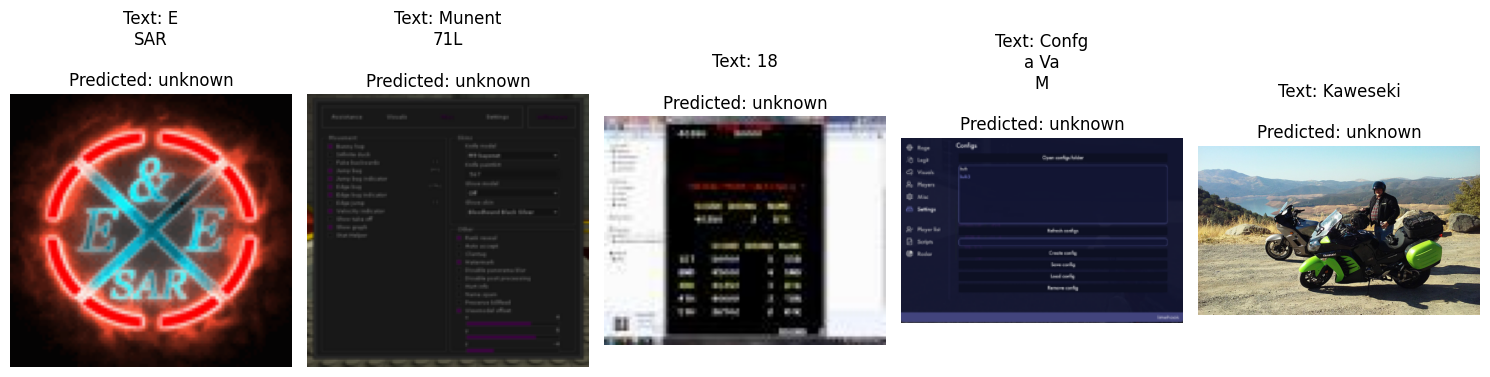

In [34]:
display_images_from_df(unknown_text_diff_predicted_val)
display_images_from_df(unknown_predicted_diff_text_val)

In [35]:
def calculate_metrics(df):
    TP = len(df[(df['predicted_text'] == 'unknown') & (df['text'] == 'unknown')])
    TN = len(df[(df['predicted_text'] == 'TBD') & (df['text'] != 'unknown')])
    FP = len(df[(df['predicted_text'] == 'unknown') & (df['text'] != 'unknown')])
    FN = len(df[(df['predicted_text'] != 'unknown') & (df['text'] == 'unknown')])

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)

    return TP, TN, FP, FN, precision, recall, accuracy, f1

In [36]:
def plot_confusion_matrix(df):
    TP, TN, FP, FN, precision, recall, accuracy, f1 = calculate_metrics(df)
    cm = np.array([[TN, FP], [FN, TP]])

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Image With Text", "No-Text Image"], rotation=45)
    plt.yticks(tick_marks, ["Image With Text", "No-Text Image"])

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")

In [37]:
def plot_false_negatives_text_length_counts(df):
    """
    Plots the count of false negatives for each text length in the given dataframe.

    Parameters:
    - df: A pandas DataFrame with columns 'predicted_text' and 'text'.

    Returns:
    - None, but displays a bar chart.
    """

    false_negatives = df[(df['predicted_text'] == 'unknown') & (df['text'] != 'unknown')]

    # Calculate the lengths
    text_lengths = false_negatives['text'].apply(len)

    # Get counts for each text length
    text_length_counts = text_lengths.value_counts().sort_index()

    text_length_counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Count of False Negatives for Each Text Length')
    plt.xlabel('Text Length')
    plt.ylabel('Number of False Negatives')
    plt.show()

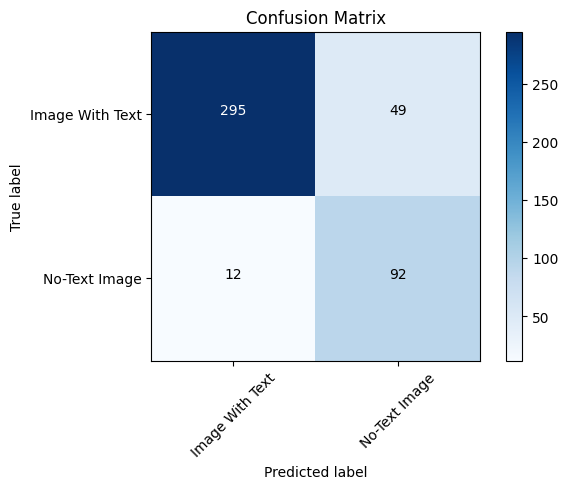

Precision: 0.6525
Recall: 0.8846
Accuracy: 0.8638
F1 Score: 0.7510


In [38]:
plot_confusion_matrix(val_df_east)

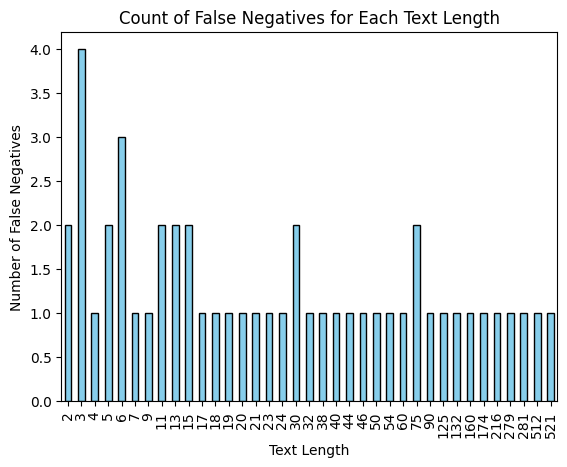

In [39]:
plot_false_negatives_text_length_counts(val_df_east)

## With Tesseract

In [40]:
val_df_Tesseract=val_df.copy()

In [41]:
url = "https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin"
filename = "lid.176.bin"

urllib.request.urlretrieve(url, filename)
print(f"{filename} has been downloaded successfully!")


lid.176.bin has been downloaded successfully!


In [42]:
# Load a pretrained FastText model for language detection
lang_model = fasttext.load_model('lid.176.bin')

In [43]:
counter = 0

In [44]:
def enhanced_ocr(image_path):
    """
    Pre-process and recognize text from an image using Tesseract with enhanced configurations.

    Parameters:
    image_path (str): Path to the image file.

    Returns:
    str: Recognized text from the image.
    """
    global counter
    counter += 1
    start_time = time.time()

    # Pre-processing
    img = Image.open(image_path).convert("L")  # Convert to grayscale
    img = ImageOps.autocontrast(img)           # Improve contrast
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(2)                  # Sharpen the image

    # Possible rotations
    rotations = [0, 90, 180, 270]
    best_text = ''
    best_angle = 0

    # Try OCR on different rotations and choose the one with the maximum length output
    for angle in rotations:
        rotated_img = img.rotate(angle)
        try:
          text = pytesseract.image_to_string(rotated_img, config='--psm 11', timeout=0.4)  # 0.4 seconds timeout
        except RuntimeError:
          print("Tesseract processing timed out for image!")
          return 'TBD'
        if len(text) > len(best_text):
            best_text = text
            best_angle = angle

        if len(best_text) > 10:
            break

    # Check if there's no or very short text
    if len(best_text) < 8:
        elapsed_time = time.time() - start_time
        print(f"Processed {counter} images. Current image took: {elapsed_time:.2f} seconds. Result: unknown")
        return 'unknown'

    elapsed_time = time.time() - start_time
    print(f"Processed {counter} images. Current image took: {elapsed_time:.2f} seconds. Result length: {len(best_text)}")
    return 'TBD'

In [45]:
wrapper_start_time = time.time()
val_df_Tesseract.loc[val_df_Tesseract['predicted_text'] == 'TBD', 'predicted_text'] = val_df_Tesseract[val_df_Tesseract['predicted_text'] == 'TBD']['file_path'].apply(enhanced_ocr)
total_elapsed_time = time.time() - wrapper_start_time
print(f"Total execution time: {total_elapsed_time}")

Processed 1 images. Current image took: 0.89 seconds. Result: unknown
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Processed 7 images. Current image took: 0.41 seconds. Result: unknown
Processed 8 images. Current image took: 0.50 seconds. Result length: 63
Processed 9 images. Current image took: 0.24 seconds. Result length: 13
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Processed 12 images. Current image took: 0.29 seconds. Result length: 34
Tesseract processing timed out for image!
Tesseract processing timed out for image!


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Processed 15 images. Current image took: 0.43 seconds. Result: unknown
Tesseract processing timed out for image!


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Processed 17 images. Current image took: 0.41 seconds. Result: unknown
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Processed 21 images. Current image took: 0.36 seconds. Result length: 51
Tesseract processing timed out for image!
Processed 23 images. Current image took: 0.18 seconds. Result length: 36
Tesseract processing timed out for image!
Processed 25 images. Current image took: 0.23 seconds. Result length: 12
Processed 26 images. Current image took: 0.38 seconds. Result: unknown
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Processed 31 images. Current image took: 0.53 seconds. Result length: 12
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Processed 35 images. Current image took: 0.36 seconds. Result 

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Processed 41 images. Current image took: 0.41 seconds. Result: unknown
Processed 42 images. Current image took: 0.25 seconds. Result length: 102
Tesseract processing timed out for image!
Processed 44 images. Current image took: 0.42 seconds. Result length: 40
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Processed 51 images. Current image took: 0.29 seconds. Result length: 28
Tesseract processing timed out for image!
Processed 53 images. Current image took: 0.28 seconds. Result length: 65
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesser

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Processed 75 images. Current image took: 0.46 seconds. Result: unknown
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Processed 78 images. Current image took: 0.17 seconds. Result length: 12
Processed 79 images. Current image took: 0.40 seconds. Result: unknown
Tesseract processing timed out for image!
Processed 81 images. Current image took: 0.41 seconds. Result: unknown
Processed 82 images. Current image took: 0.66 seconds. Result: unknown
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Processed 87 images. Current image took: 0.34 seconds. Result length: 97
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Processed 90 images. Current image took: 0.17 seconds. Result length: 24
Tesseract processing timed out for image!
Processed 92 images. Current image took: 0.27 seconds. Result length: 11
Proc

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Processed 113 images. Current image took: 0.41 seconds. Result: unknown
Tesseract processing timed out for image!
Tesseract processing timed out for image!


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Processed 116 images. Current image took: 0.25 seconds. Result length: 11
Processed 117 images. Current image took: 0.15 seconds. Result length: 16


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Processed 121 images. Current image took: 0.43 seconds. Result: unknown
Tesseract processing timed out for image!
Processed 123 images. Current image took: 0.57 seconds. Result: unknown
Processed 124 images. Current image took: 0.28 seconds. Result length: 23
Tesseract processing timed out for image!
Processed 126 images. Current image took: 0.90 seconds. Result length: 9
Tesseract processing timed out for image!


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Processed 128 images. Current image took: 0.75 seconds. Result: unknown
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Processed 131 images. Current image took: 0.97 seconds. Result: unknown
Processed 132 images. Current image took: 0.55 seconds. Result length: 23
Processed 133 images. Current image took: 0.40 seconds. Result length: 91
Processed 134 images. Current image took: 0.23 seconds. Result length: 34
Processed 135 images. Current image took: 0.19 seconds. Result length: 29
Tesseract processing timed out for image!
Processed 137 images. Current image took: 0.20 seconds. Result length: 18
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Processed 143 images. Current image took: 0.24 seconds. Result length: 39
Tesseract processing timed out for image!
Tesseract processing timed out for

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Processed 191 images. Current image took: 0.40 seconds. Result length: 13
Tesseract processing timed out for image!
Processed 193 images. Current image took: 0.36 seconds. Result length: 26
Tesseract processing timed out for image!
Processed 195 images. Current image took: 0.40 seconds. Result length: 18
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Processed 200 images. Current image took: 0.44 seconds. Result length: 14
Processed 201 images. Current image took: 0.32 seconds. Result length: 20
Processed 202 images. Current image took: 0.57 seconds. Result length: 10
Processed 203 images. Current image took: 0.38 seconds. Result: unknown
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Processed 206 images. Current image took: 0.42 seconds. Result: unknown
Processed 207 images. Current image took: 0.34 seconds. Result length: 44
Pr

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Processed 362 images. Current image took: 0.72 seconds. Result: unknown
Processed 363 images. Current image took: 0.91 seconds. Result: unknown
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Processed 370 images. Current image took: 0.40 seconds. Result: unknown
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Tesseract processing timed out for image!
Processed 374 images. Current image took: 0.39 seconds. Result: unknown
Processed 375 images. Current image took: 0.42 seconds. Result: unknown
Processed 376 images. Current image took: 0.25 seconds. Result length: 60
Tesseract processing timed out for image!
Processed 378 images. Current image took: 0.45 seconds. Result length: 69
Processed 379 images. Current image took: 0.41 seconds. Result: unknown


In [46]:
correct_predictions = ((val_df_Tesseract['predicted_text'] == val_df_Tesseract['text'])).sum()

total_predictions = len(val_df_Tesseract)

accuracy = (correct_predictions / total_predictions) * 100

print(f"Accuracy after handling 'n_a_images', one-color images, and no-text images: {accuracy:.4f}%")


Accuracy after handling 'n_a_images', one-color images, and no-text images: 17.2485%


In [47]:
# Rows where 'text' is 'unknown' but 'predicted_text' is not
unknown_text_diff_predicted_val = val_df_Tesseract[(val_df_Tesseract['text'] == 'unknown') & (val_df_Tesseract['predicted_text'] != 'unknown')]

# Rows where 'predicted_text' is 'unknown' but 'text' is not
unknown_predicted_diff_text_val = val_df_Tesseract[(val_df_Tesseract['predicted_text'] == 'unknown') & (val_df_Tesseract['text'] != 'unknown')]

# Calculate percentages
percentage_unknown_text_diff_predicted_val = (len(unknown_text_diff_predicted_val) / len(val_df_Tesseract)) * 100
percentage_unknown_predicted_diff_text_val = (len(unknown_predicted_diff_text_val) / len(val_df_Tesseract)) * 100

print(f"Percentage where 'text' in val_df is 'unknown' but 'predicted_text' is not: {percentage_unknown_text_diff_predicted_val:.2f}%")
print(f"Percentage where 'predicted_text' in val_df is 'unknown' but 'text' is not: {percentage_unknown_predicted_diff_text_val:.2f}%")


Percentage where 'text' in val_df is 'unknown' but 'predicted_text' is not: 10.27%
Percentage where 'predicted_text' in val_df is 'unknown' but 'text' is not: 3.08%


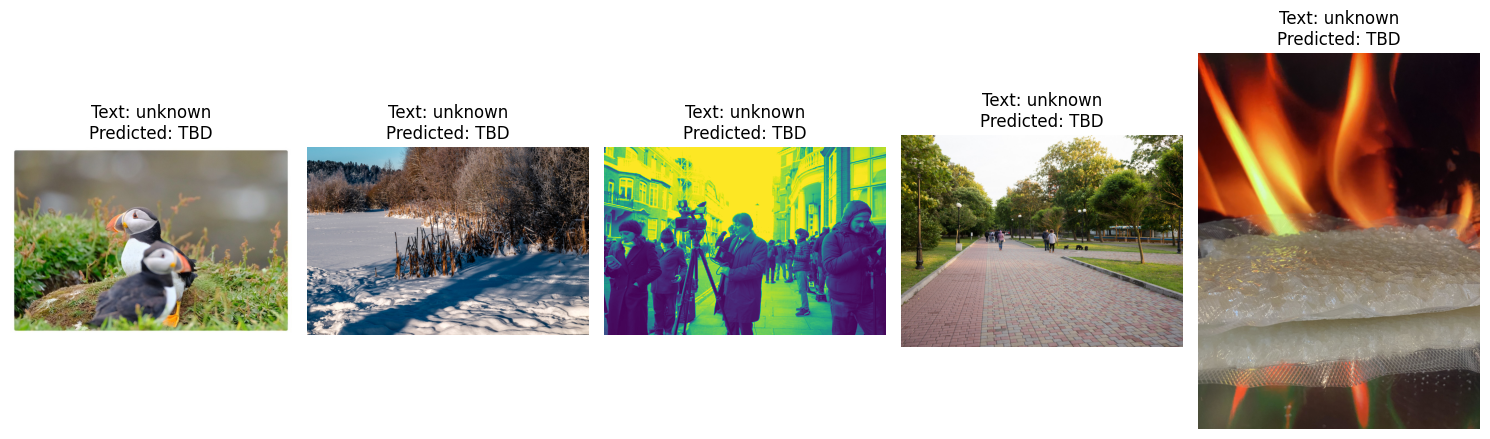

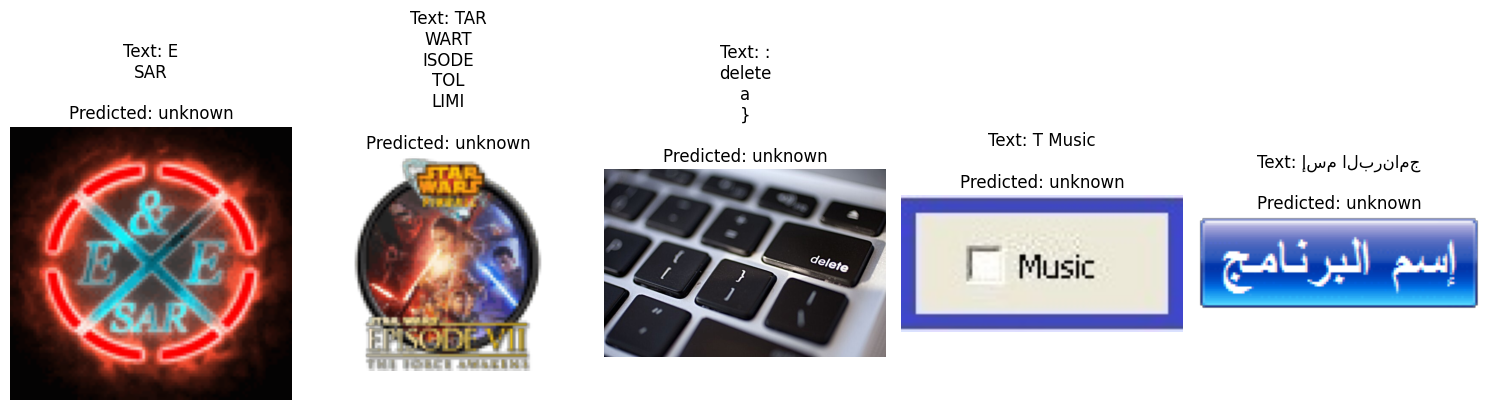

In [48]:
display_images_from_df(unknown_text_diff_predicted_val)
display_images_from_df(unknown_predicted_diff_text_val)

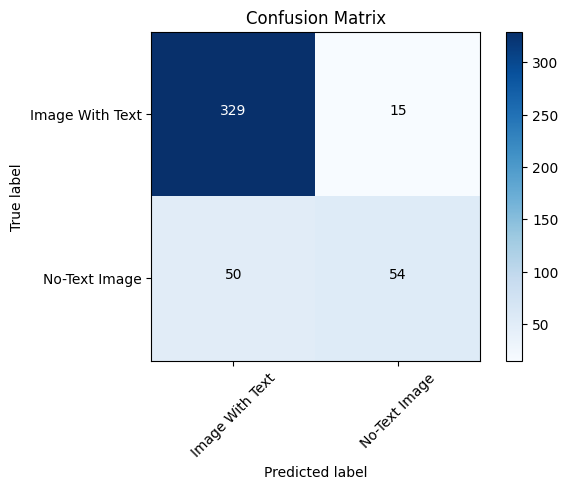

Precision: 0.7826
Recall: 0.5192
Accuracy: 0.8549
F1 Score: 0.6243


In [49]:
plot_confusion_matrix(val_df_Tesseract)

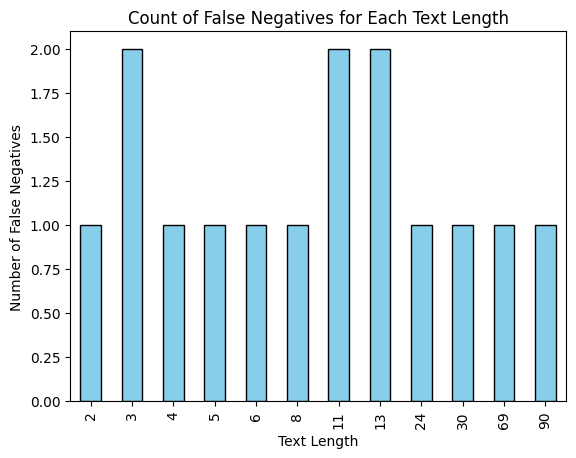

In [50]:
plot_false_negatives_text_length_counts(val_df_Tesseract)

## Combined

In [51]:
val_df_combined=val_df.copy()

In [52]:
counter_east_combined = 0

In [53]:
counter_ocr_combined = 0

In [54]:
def detect_bb_text_east(image_path):
    global counter_east_combined
    counter_east_combined += 1
    # Read image
    image = cv2.imread(image_path)
    if image is None:
      print(f"IN EDETECT BB: Failed to read image at {image_path}. Skipping...")
      return []

    start_time = time.time()

    orig = image.copy()
    (H, W) = image.shape[:2]

    # Set the new width and height and then determine the ratio in change
    (newW, newH) = (320, 320)
    rW = W / float(newW)
    rH = H / float(newH)

    # Resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]

    # Define the two output layer names for the EAST detector model
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"]

    # Convert image to blob for DNN
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
        (123.68, 116.78, 103.94), swapRB=True, crop=False)

    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)

    # Decode the predictions
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(0, numCols):
            if scoresData[x] < 0.4:
                continue

            # Compute the offset factor
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # Extract the rotation angle for the prediction and compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # Use the geometry volume to derive the width and height of the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # Compute both the starting and ending (x, y)-coordinates for the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
    elapsed_time = time.time() - start_time
    print(f"IN DETECT BB: Processed {counter_east_combined} images. Current image took: {elapsed_time:.2f} seconds.")
    # Return True if we found some text regions with high confidence
    return rects if len(confidences) > 0 and max(confidences) > 0.45 else []

In [55]:
def enhanced_ocr_combined(image_path):
    global counter_ocr_combined
    counter_ocr_combined += 1
    start_time = time.time()

    # Pre-processing
    img = Image.open(image_path).convert("L")  # Convert to grayscale
    img = ImageOps.autocontrast(img)           # Improve contrast
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(2)                  # Sharpen the image

    # Detect text regions with EAST
    rects = detect_bb_text_east(image_path)
    # If there are bounding boxes detected by EAST, classify them as containing text
    if len(rects)>8:
        elapsed_time = time.time() - start_time
        print(f"IN THE COMBINED FUNCION: Processed {counter_ocr_combined} images. Current image took: {elapsed_time:.2f} seconds. Text detected in {len(rects)} bounding boxes.")
        return 'TBD'

    # If EAST did not detect any text regions, process the entire image with Tesseract
    try:
        text = pytesseract.image_to_string(img, config='--psm 3', timeout = 0.4)
        elapsed_time = time.time() - start_time
        print(f"IN THE COMBINED FUNCION: Processed {counter_ocr_combined} images. Current image took: {elapsed_time:.2f} seconds. Result length: {len(text)}")
        return 'TBD' if len(text) > 4 else 'unknown'
    except RuntimeError:
        print("IN THE COMBINED FUNCION: Tesseract processing timed out for image!")
        return 'TBD'

    return 'unknown'



In [56]:
val_df_combined.loc[val_df_combined['predicted_text'] == 'TBD', 'predicted_text'] = val_df_combined[val_df_combined['predicted_text'] == 'TBD']['file_path'].apply(enhanced_ocr_combined)


IN EDETECT BB: Failed to read image at /content/drive/MyDrive/Data/Data_samples/forum_anticollector/8fe1f01474df8aebbbc5af5532bac507.jpg. Skipping...
IN THE COMBINED FUNCION: Processed 1 images. Current image took: 0.10 seconds. Result length: 1
IN DETECT BB: Processed 2 images. Current image took: 0.27 seconds.
IN THE COMBINED FUNCION: Processed 2 images. Current image took: 0.32 seconds. Text detected in 90 bounding boxes.
IN DETECT BB: Processed 3 images. Current image took: 0.25 seconds.
IN THE COMBINED FUNCION: Processed 3 images. Current image took: 0.32 seconds. Text detected in 86 bounding boxes.
IN DETECT BB: Processed 4 images. Current image took: 0.26 seconds.
IN THE COMBINED FUNCION: Processed 4 images. Current image took: 0.29 seconds. Text detected in 13 bounding boxes.
IN DETECT BB: Processed 5 images. Current image took: 0.25 seconds.
IN THE COMBINED FUNCION: Processed 5 images. Current image took: 0.27 seconds. Text detected in 143 bounding boxes.
IN DETECT BB: Process

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


IN DETECT BB: Processed 15 images. Current image took: 0.27 seconds.
IN THE COMBINED FUNCION: Processed 15 images. Current image took: 0.37 seconds. Result length: 1
IN DETECT BB: Processed 16 images. Current image took: 0.28 seconds.
IN THE COMBINED FUNCION: Processed 16 images. Current image took: 0.32 seconds. Text detected in 149 bounding boxes.


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


IN DETECT BB: Processed 17 images. Current image took: 0.30 seconds.
IN THE COMBINED FUNCION: Processed 17 images. Current image took: 0.48 seconds. Result length: 1
IN DETECT BB: Processed 18 images. Current image took: 0.43 seconds.
IN THE COMBINED FUNCION: Processed 18 images. Current image took: 0.58 seconds. Text detected in 146 bounding boxes.
IN DETECT BB: Processed 19 images. Current image took: 0.40 seconds.
IN THE COMBINED FUNCION: Processed 19 images. Current image took: 0.45 seconds. Text detected in 42 bounding boxes.
IN DETECT BB: Processed 20 images. Current image took: 0.43 seconds.
IN THE COMBINED FUNCION: Tesseract processing timed out for image!
IN DETECT BB: Processed 21 images. Current image took: 0.44 seconds.
IN THE COMBINED FUNCION: Processed 21 images. Current image took: 0.65 seconds. Result length: 3
IN DETECT BB: Processed 22 images. Current image took: 0.42 seconds.
IN THE COMBINED FUNCION: Processed 22 images. Current image took: 0.47 seconds. Text detecte

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


IN DETECT BB: Processed 41 images. Current image took: 0.26 seconds.
IN THE COMBINED FUNCION: Processed 41 images. Current image took: 0.36 seconds. Result length: 1
IN DETECT BB: Processed 42 images. Current image took: 0.26 seconds.
IN THE COMBINED FUNCION: Processed 42 images. Current image took: 0.27 seconds. Text detected in 144 bounding boxes.
IN DETECT BB: Processed 43 images. Current image took: 0.26 seconds.
IN THE COMBINED FUNCION: Processed 43 images. Current image took: 0.28 seconds. Text detected in 117 bounding boxes.
IN DETECT BB: Processed 44 images. Current image took: 0.26 seconds.
IN THE COMBINED FUNCION: Processed 44 images. Current image took: 0.67 seconds. Result length: 29
IN DETECT BB: Processed 45 images. Current image took: 0.27 seconds.
IN THE COMBINED FUNCION: Processed 45 images. Current image took: 0.54 seconds. Result length: 3
IN DETECT BB: Processed 46 images. Current image took: 0.26 seconds.
IN THE COMBINED FUNCION: Processed 46 images. Current image 

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


IN DETECT BB: Processed 75 images. Current image took: 0.26 seconds.
IN THE COMBINED FUNCION: Processed 75 images. Current image took: 0.38 seconds. Result length: 3
IN DETECT BB: Processed 76 images. Current image took: 0.27 seconds.
IN THE COMBINED FUNCION: Processed 76 images. Current image took: 0.29 seconds. Text detected in 139 bounding boxes.
IN DETECT BB: Processed 77 images. Current image took: 0.27 seconds.
IN THE COMBINED FUNCION: Processed 77 images. Current image took: 0.28 seconds. Text detected in 321 bounding boxes.
IN DETECT BB: Processed 78 images. Current image took: 0.25 seconds.
IN THE COMBINED FUNCION: Processed 78 images. Current image took: 0.26 seconds. Text detected in 13 bounding boxes.
IN DETECT BB: Processed 79 images. Current image took: 0.26 seconds.
IN THE COMBINED FUNCION: Processed 79 images. Current image took: 0.37 seconds. Result length: 3
IN DETECT BB: Processed 80 images. Current image took: 0.26 seconds.
IN THE COMBINED FUNCION: Processed 80 imag

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


IN DETECT BB: Processed 113 images. Current image took: 0.25 seconds.
IN THE COMBINED FUNCION: Processed 113 images. Current image took: 0.36 seconds. Result length: 1
IN DETECT BB: Processed 114 images. Current image took: 0.25 seconds.
IN THE COMBINED FUNCION: Processed 114 images. Current image took: 0.31 seconds. Text detected in 67 bounding boxes.
IN DETECT BB: Processed 115 images. Current image took: 0.26 seconds.
IN THE COMBINED FUNCION: Processed 115 images. Current image took: 0.31 seconds. Text detected in 144 bounding boxes.


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


IN DETECT BB: Processed 116 images. Current image took: 0.26 seconds.
IN THE COMBINED FUNCION: Processed 116 images. Current image took: 0.37 seconds. Result length: 1


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


IN DETECT BB: Processed 117 images. Current image took: 0.27 seconds.
IN THE COMBINED FUNCION: Processed 117 images. Current image took: 0.28 seconds. Text detected in 104 bounding boxes.
IN DETECT BB: Processed 118 images. Current image took: 0.27 seconds.
IN THE COMBINED FUNCION: Processed 118 images. Current image took: 0.27 seconds. Text detected in 787 bounding boxes.
IN DETECT BB: Processed 119 images. Current image took: 0.27 seconds.
IN THE COMBINED FUNCION: Processed 119 images. Current image took: 0.30 seconds. Text detected in 10 bounding boxes.
IN DETECT BB: Processed 120 images. Current image took: 0.26 seconds.
IN THE COMBINED FUNCION: Processed 120 images. Current image took: 0.28 seconds. Text detected in 245 bounding boxes.
IN DETECT BB: Processed 121 images. Current image took: 0.27 seconds.
IN THE COMBINED FUNCION: Processed 121 images. Current image took: 0.38 seconds. Result length: 1
IN DETECT BB: Processed 122 images. Current image took: 0.28 seconds.
IN THE COMB

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


IN DETECT BB: Processed 128 images. Current image took: 0.27 seconds.
IN THE COMBINED FUNCION: Processed 128 images. Current image took: 0.28 seconds. Text detected in 70 bounding boxes.
IN DETECT BB: Processed 129 images. Current image took: 0.25 seconds.
IN THE COMBINED FUNCION: Processed 129 images. Current image took: 0.27 seconds. Text detected in 38 bounding boxes.
IN DETECT BB: Processed 130 images. Current image took: 0.25 seconds.
IN THE COMBINED FUNCION: Processed 130 images. Current image took: 0.29 seconds. Text detected in 10 bounding boxes.
IN DETECT BB: Processed 131 images. Current image took: 0.26 seconds.
IN THE COMBINED FUNCION: Processed 131 images. Current image took: 0.39 seconds. Result length: 3
IN DETECT BB: Processed 132 images. Current image took: 0.26 seconds.
IN THE COMBINED FUNCION: Processed 132 images. Current image took: 0.26 seconds. Text detected in 156 bounding boxes.
IN DETECT BB: Processed 133 images. Current image took: 0.25 seconds.
IN THE COMBIN

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


IN DETECT BB: Processed 191 images. Current image took: 0.25 seconds.
IN THE COMBINED FUNCION: Processed 191 images. Current image took: 0.35 seconds. Result length: 1
IN DETECT BB: Processed 192 images. Current image took: 0.26 seconds.
IN THE COMBINED FUNCION: Processed 192 images. Current image took: 0.64 seconds. Result length: 71
IN DETECT BB: Processed 193 images. Current image took: 0.25 seconds.
IN THE COMBINED FUNCION: Processed 193 images. Current image took: 0.26 seconds. Text detected in 35 bounding boxes.
IN DETECT BB: Processed 194 images. Current image took: 0.25 seconds.
IN THE COMBINED FUNCION: Processed 194 images. Current image took: 0.30 seconds. Text detected in 43 bounding boxes.
IN DETECT BB: Processed 195 images. Current image took: 0.26 seconds.
IN THE COMBINED FUNCION: Processed 195 images. Current image took: 0.46 seconds. Result length: 3
IN DETECT BB: Processed 196 images. Current image took: 0.25 seconds.
IN THE COMBINED FUNCION: Processed 196 images. Curr

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


IN DETECT BB: Processed 362 images. Current image took: 0.26 seconds.
IN THE COMBINED FUNCION: Processed 362 images. Current image took: 0.39 seconds. Result length: 1
IN DETECT BB: Processed 363 images. Current image took: 0.28 seconds.
IN THE COMBINED FUNCION: Processed 363 images. Current image took: 0.43 seconds. Result length: 3
IN DETECT BB: Processed 364 images. Current image took: 0.26 seconds.
IN THE COMBINED FUNCION: Processed 364 images. Current image took: 0.28 seconds. Text detected in 60 bounding boxes.
IN DETECT BB: Processed 365 images. Current image took: 0.28 seconds.
IN THE COMBINED FUNCION: Processed 365 images. Current image took: 0.30 seconds. Text detected in 121 bounding boxes.
IN DETECT BB: Processed 366 images. Current image took: 0.26 seconds.
IN THE COMBINED FUNCION: Processed 366 images. Current image took: 0.27 seconds. Text detected in 241 bounding boxes.
IN DETECT BB: Processed 367 images. Current image took: 0.27 seconds.
IN THE COMBINED FUNCION: Proces

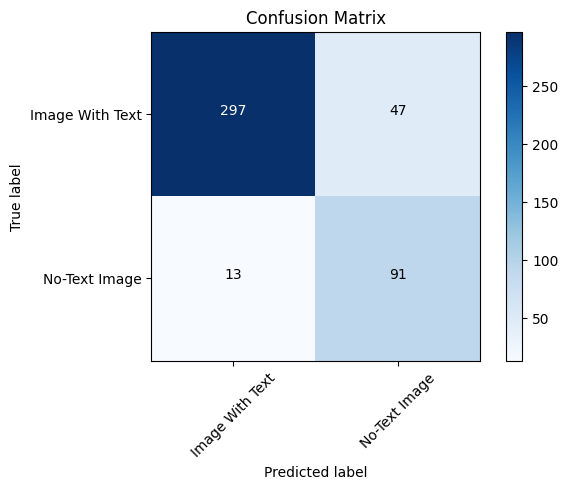

Precision: 0.6594
Recall: 0.8750
Accuracy: 0.8661
F1 Score: 0.7521


In [57]:
plot_confusion_matrix(val_df_combined)

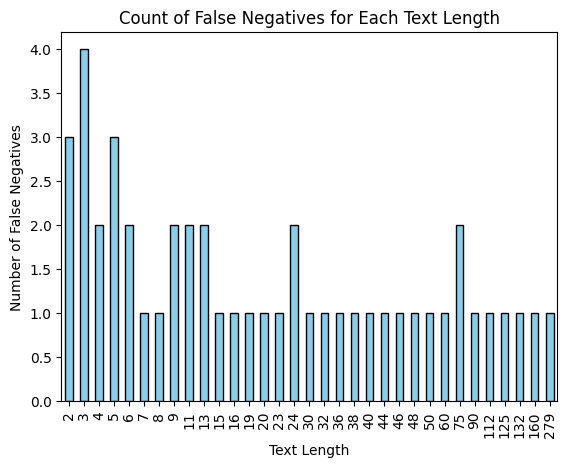

In [58]:
plot_false_negatives_text_length_counts(val_df_combined)

In [59]:
# Rows where 'text' is 'unknown' but 'predicted_text' is not
unknown_text_diff_predicted_val = val_df_combined[(val_df_combined['text'] == 'unknown') & (val_df_combined['predicted_text'] != 'unknown')]

# Rows where 'predicted_text' is 'unknown' but 'text' is not
unknown_predicted_diff_text_val = val_df_combined[(val_df_combined['predicted_text'] == 'unknown') & (val_df_combined['text'] != 'unknown')]

# Calculate percentages
percentage_unknown_text_diff_predicted_val = (len(unknown_text_diff_predicted_val) / len(val_df_combined)) * 100
percentage_unknown_predicted_diff_text_val = (len(unknown_predicted_diff_text_val) / len(val_df_combined)) * 100

print(f"Percentage where 'text' in val_df is 'unknown' but 'predicted_text' is not: {percentage_unknown_text_diff_predicted_val:.2f}%")
print(f"Percentage where 'predicted_text' in val_df is 'unknown' but 'text' is not: {percentage_unknown_predicted_diff_text_val:.2f}%")


Percentage where 'text' in val_df is 'unknown' but 'predicted_text' is not: 2.67%
Percentage where 'predicted_text' in val_df is 'unknown' but 'text' is not: 9.65%


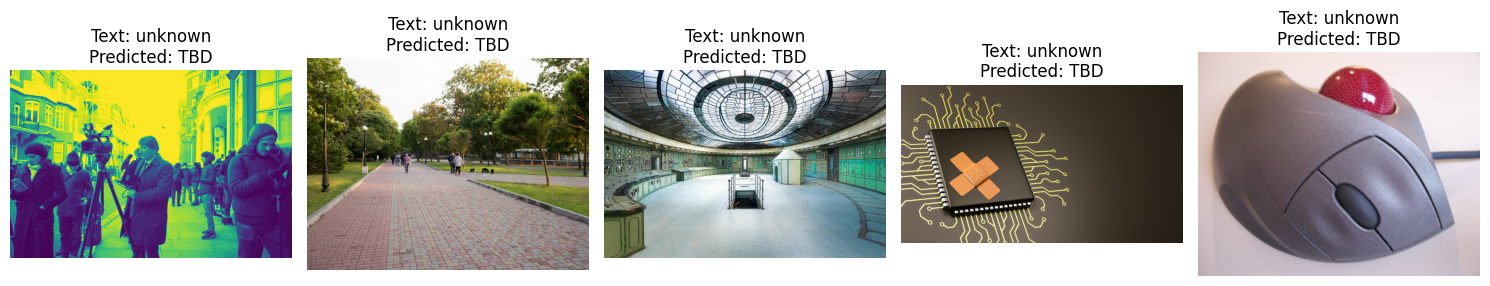

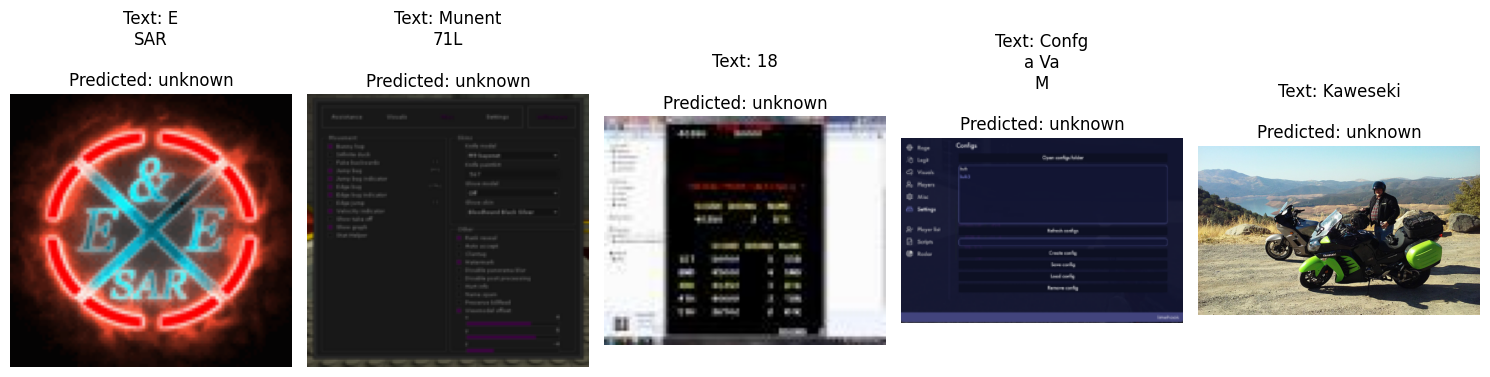

In [60]:
display_images_from_df(unknown_text_diff_predicted_val)
display_images_from_df(unknown_predicted_diff_text_val)